In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import arch.unitroot as at

In [2]:
conf_int_to_drop = [0.90]  # drop list for intervals
# conf_int_to_drop = [0.90, 0.95]  # drop list for intervals

In [3]:
df = pd.read_pickle("pairs_to_download.pkl")

tickers_list = list(df.index.union(df.columns))

x_list = df.index.tolist()
y_list = df.columns.tolist()

pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df.iloc[i,j]>0:
            pairs_list.append((x_list[i], y_list[j]))

print(f"{len(pairs_list)} pairs")
pairs_list

18 pairs


[('BTCUSDT', 'NEOUSDT'),
 ('BTCUSDT', 'TRXUSDT'),
 ('ETHUSDT', 'TRXUSDT'),
 ('XRPUSDT', 'TRXUSDT'),
 ('ADAUSDT', 'SOLUSDT'),
 ('ADAUSDT', 'TRXUSDT'),
 ('DOGEUSDT', 'VETUSDT'),
 ('EOSUSDT', 'TRXUSDT'),
 ('XLMUSDT', 'TRXUSDT'),
 ('XLMUSDT', 'NEARUSDT'),
 ('SOLUSDT', 'TRXUSDT'),
 ('SOLUSDT', 'NEARUSDT'),
 ('NEOUSDT', 'LTCUSDT'),
 ('NEOUSDT', 'TRXUSDT'),
 ('LINKUSDT', 'TRXUSDT'),
 ('LINKUSDT', 'NEARUSDT'),
 ('UNIUSDT', 'NEARUSDT'),
 ('VETUSDT', 'DOTUSDT')]

In [4]:
prices= pd.read_pickle("close_prices.pkl")[tickers_list] 
prices

,ADAUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,EOSUSDT,ETHUSDT,LINKUSDT,LTCUSDT,NEARUSDT,NEOUSDT,SOLUSDT,TRXUSDT,UNIUSDT,VETUSDT,XLMUSDT,XRPUSDT
timestamp,,,,,,,,,,,,,,,,
2022-04-01,1.1650,46283.49,0.14130,22.070,2.838,3455.21,17.340,124.80,14.740,28.03,134.52,0.07494,11.580,0.08108,0.2325,0.8277
2022-04-02,1.1550,45811.00,0.13870,22.610,2.786,3443.77,17.400,124.80,14.825,27.53,132.49,0.07322,11.650,0.07716,0.2331,0.8240
2022-04-03,1.1860,46407.35,0.14660,23.210,2.840,3521.91,18.080,128.70,16.813,28.00,136.90,0.07312,11.870,0.08262,0.2370,0.8432
2022-04-04,1.2120,46580.51,0.14850,22.890,2.890,3519.50,17.500,124.80,17.115,27.18,132.14,0.07070,11.540,0.07890,0.2319,0.8260
2022-04-05,1.1710,45497.55,0.17270,21.780,2.753,3406.99,16.740,122.70,16.140,25.76,126.87,0.06928,11.120,0.07584,0.2248,0.8164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28,0.3681,27261.07,0.07381,6.056,1.113,1772.99,6.947,89.13,1.883,12.72,20.45,0.06418,5.808,0.02242,0.0977,0.5144
2023-03-29,0.3811,28348.60,0.07557,6.183,1.149,1793.07,7.382,91.31,2.000,13.22,21.10,0.06433,5.945,0.02321,0.1017,0.5425
2023-03-30,0.3761,28028.53,0.07422,6.122,1.190,1793.61,7.233,89.06,1.927,12.51,20.55,0.06481,5.897,0.02287,0.1064,0.5319


TESTS

COINTEGRATION TEST

In [5]:
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    confints = np.zeros((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue
            
            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))
                if result[2][0]>test_stat:
                    confints[i, j]=0.99 
                elif result[2][1]>test_stat:
                    confints[i, j]=0.95
                elif result[2][2]>test_stat:
                    confints[i, j]=0.90
                else:
                    confints[i, j]=1-pvalue               
    return stats, pvalues, pairs, confints

In [6]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs, confints = cointegration_test(prices,p_value)

remaining 18 pairs from 18


,NEARUSDT,NEOUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
ADAUSDT,nan,nan,0.99,0.99,nan,nan,nan
BTCUSDT,nan,0.95,nan,0.99,nan,nan,nan
DOGEUSDT,nan,nan,nan,nan,0.90,nan,0.90
DOTUSDT,nan,nan,nan,0.99,0.99,nan,nan
EOSUSDT,nan,nan,nan,0.99,nan,nan,nan
ETHUSDT,nan,nan,nan,0.95,nan,nan,nan
LINKUSDT,0.99,nan,nan,0.99,nan,nan,nan
NEARUSDT,nan,nan,0.99,0.99,nan,0.95,nan
NEOUSDT,nan,nan,nan,0.99,nan,nan,nan
SOLUSDT,nan,nan,nan,0.95,nan,nan,nan


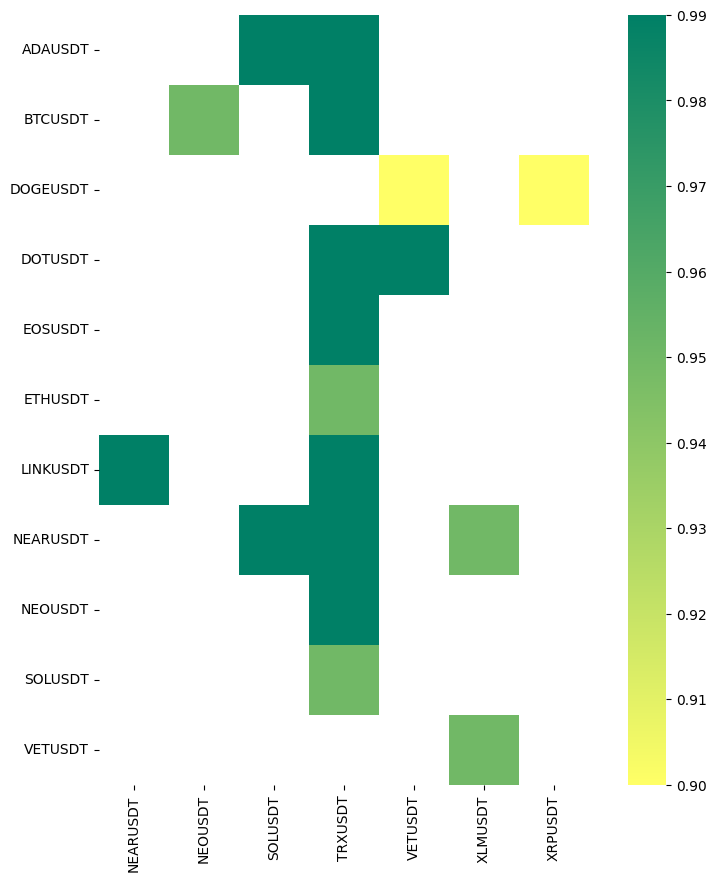

In [7]:
# mask_matrix = (pvalues >= p_value) # possible to increase the level of significance
conf_int = 0.90
mask_matrix = (confints < conf_int) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= tickers_list, columns = tickers_list)
pvalues_df = pd.DataFrame(pvalues, index= tickers_list, columns = tickers_list)
confints_df = pd.DataFrame(confints, index= tickers_list, columns = tickers_list)

df_p = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_p = df_p.dropna(how='all')

df_c = confints_df[~mask_df].dropna(how='all', axis=1)
df_c = df_c.dropna(how='all')


def green_apply(x):
    green = {True: "background-color: green", False: "color : white"}
    is_color = (x > 0.95).replace(green)
    return is_color

def yellow_apply(x):
    yellow = {True: "background-color: yellow; color : black"}
    is_color = (x <= 0.95).replace(yellow)
    return is_color

# kept it here although we don't expect to see any red backgroud
def red_apply(x):
    red = {True: "background-color: red;"}
    is_color = (x <= 0.90).replace(red)
    return is_color

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_c,
    xticklabels=df_c.columns,
    yticklabels=df_c.index,
    cmap="summer_r",
    square=True,
    vmin=0.90,
    vmax=0.99
)

print(f"remaining {df_c.count().sum()} pairs from {len(pairs_list)}")

df_c.style.format(precision=2)\
.apply(green_apply)\
.apply(yellow_apply)\
.apply(red_apply)

UNIT ROOT TESTS

In [8]:
df_c_adf = df_c.copy()
df_c_pp = df_c.copy()
hedges ={}

N=90
enable_regression_coef = 0

# get new pairs
x_list = df_c.index.tolist()
y_list = df_c.columns.tolist()

pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df.iloc[i,j]>0:
            pairs_list.append((x_list[i], y_list[j]))

for i in range(len(pairs_list)):
    ticker1, ticker2 = list(pairs_list[i])[0], list(pairs_list[i])[1]
    prices_pair= prices[list(pairs_list[i])]
    
    ###HEDGE###
    
    if N>0:
        Y = prices_pair[ticker2].iloc[-N:]
        X = prices_pair[ticker1].iloc[-N:]
    else:
        Y = prices_pair[ticker2]
        X = prices_pair[ticker1]

    if enable_regression_coef:
        X = sm.add_constant(X)

    model = sm.OLS(Y, X)
    model = model.fit()

    if len(model.params) == 1:
        hedge = round(float(model.params[0]),2)
        alfa = 0
    else:
        hedge = round(float(model.params[1]),2)
        alfa = round(float(model.params[0]),2)
    
    hedges[(ticker1, ticker2)]=hedge
    # print pair equation
    #print(f"EQUATION: {ticker2}={hedge}*{ticker1}{'+' + str(round(alfa,1)) if alfa>0 else ''}")

    ###SPREAD###

    prices_pair_s = prices_pair.copy()
    spread = prices_pair_s['spread'] = prices_pair[ticker2] - hedge * prices_pair[ticker1] - alfa
    
    ###ADF###
    
    adf = adfuller(prices_pair_s.spread, autolag='AIC')
    test_stat_df = adf[0]
    critical_values_df = adf[4]

    if critical_values_df['1%']>test_stat_df:
        df_c_adf.loc[(ticker1,ticker2)]=0.99 
    elif critical_values_df['5%']>test_stat_df:
        df_c_adf.loc[(ticker1,ticker2)]=0.95
    elif critical_values_df['10%']>test_stat_df:
        df_c_adf.loc[(ticker1,ticker2)]=0.90
        
    ###PP###  
          
    pp = at.PhillipsPerron(prices_pair_s.spread, trend='ct', test_type='rho')
    test_stat_pp = pp.stat
    critical_values_pp = pp.critical_values

    if critical_values_pp['1%']>test_stat_pp:
        df_c_pp.loc[(ticker1,ticker2)]=0.99 
    elif critical_values_pp['5%']>test_stat_pp:
        df_c_pp.loc[(ticker1,ticker2)]=0.95
    elif critical_values_pp['10%']>test_stat_pp:
        df_c_pp.loc[(ticker1,ticker2)]=0.90

,NEARUSDT,NEOUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
ADAUSDT,nan,nan,0.99,0.99,nan,nan,nan
BTCUSDT,nan,0.95,nan,0.99,nan,nan,nan
DOGEUSDT,nan,nan,nan,0.95,0.90,nan,0.90
DOTUSDT,0.99,nan,nan,0.99,0.99,nan,nan
EOSUSDT,nan,nan,nan,0.99,0.99,nan,nan
ETHUSDT,nan,nan,nan,0.95,nan,nan,nan
LINKUSDT,0.99,nan,nan,0.99,nan,nan,0.95
NEARUSDT,nan,nan,0.99,0.99,nan,0.95,0.99
NEOUSDT,nan,nan,0.95,0.99,nan,nan,nan
SOLUSDT,nan,nan,nan,0.95,nan,nan,0.90


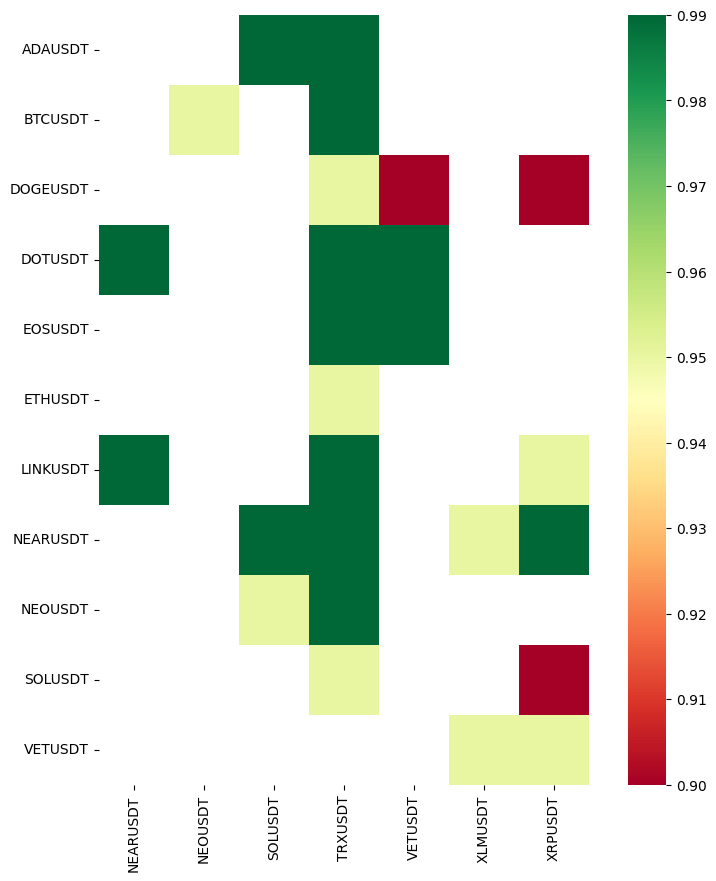

In [9]:
conf_int = 0.95

def green_apply(x):
    green = {True: "background-color: green", False: "color : white"}
    is_color = (x > conf_int).replace(green)
    return is_color

def yellow_apply(x):
    yellow = {True: "background-color: yellow; color : black"}
    is_color = (x <= conf_int).replace(yellow)
    return is_color

def red_apply(x):
    red = {True: "background-color: red"}
    is_color = (x <= 0.90).replace(red)
    return is_color

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_c_adf,
    xticklabels=df_c.columns,
    yticklabels=df_c.index,
    cmap="RdYlGn",
    #mask=(df_c_adf < conf_int),
    square=True,
    vmin=0.90,
    vmax=0.99
)
df_c_adf.style.format(precision=2)\
.apply(green_apply)\
.apply(yellow_apply)\
.apply(red_apply)

,NEARUSDT,NEOUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
ADAUSDT,nan,0.99,0.99,0.99,nan,nan,nan
BTCUSDT,nan,0.95,nan,0.95,nan,nan,nan
DOGEUSDT,nan,nan,nan,nan,0.90,nan,0.90
DOTUSDT,nan,nan,nan,0.99,0.99,nan,nan
EOSUSDT,nan,nan,nan,0.99,0.90,nan,nan
ETHUSDT,nan,nan,nan,0.95,nan,nan,nan
LINKUSDT,0.99,nan,nan,0.99,nan,nan,0.95
NEARUSDT,nan,nan,0.99,0.99,nan,0.95,nan
NEOUSDT,nan,nan,nan,0.99,nan,nan,nan
SOLUSDT,nan,nan,nan,0.95,nan,nan,nan


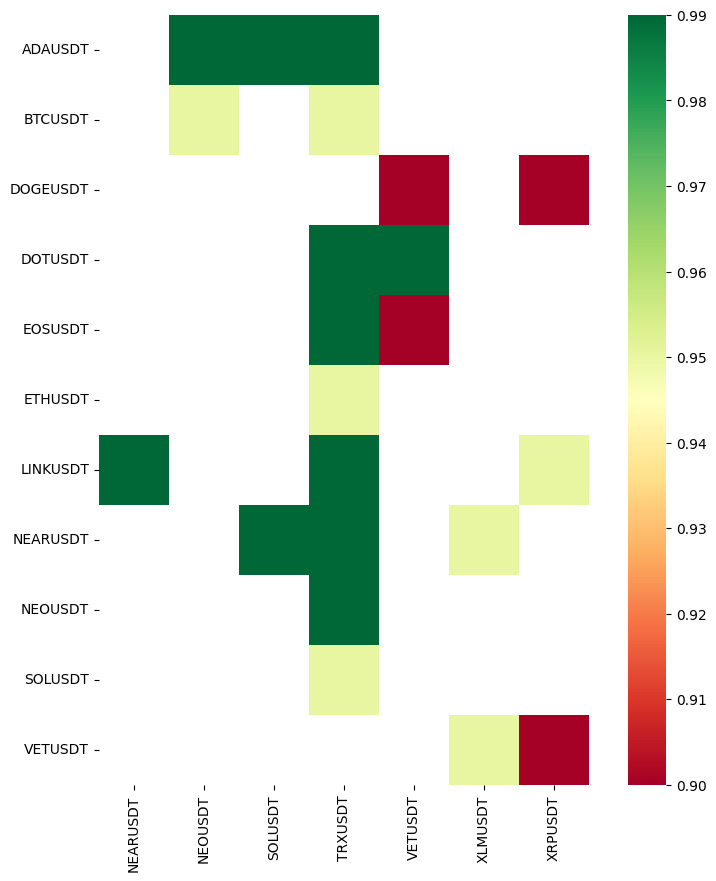

In [10]:
conf_int = 0.95

def green_apply(x):
    green = {True: "background-color: green", False: "color : white"}
    is_color = (x > conf_int).replace(green)
    return is_color

def yellow_apply(x):
    yellow = {True: "background-color: yellow; color : black"}
    is_color = (x <= conf_int).replace(yellow)
    return is_color

def red_apply(x):
    red = {True: "background-color: red"}
    is_color = (x <= 0.90).replace(red)
    return is_color

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_c_pp,
    xticklabels=df_p.columns,
    yticklabels=df_p.index,
    cmap="RdYlGn",
    #mask=(df_c_adf < conf_int),
    square=True,
    vmin=0.90,
    vmax=0.99
)
df_c_pp.style.format(precision=2)\
.apply(green_apply)\
.apply(yellow_apply)\
.apply(red_apply)

DROP PAIRS

Drop all %90 conf int values



In [ ]:
# conf_int_to_drop = [0.90, 0.95]  # drop list for intervals

In [11]:
# check for %90 conf intervals
mask_90 = df_c.isin(conf_int_to_drop)
mask_90_pp = df_c_pp.isin(conf_int_to_drop)
mask_90_adf = df_c_adf.isin(conf_int_to_drop)

# get col names
cols= mask_90.any()
cols_pp = mask_90_pp.any()
cols_adf= mask_90_adf.any()
columns = list(cols[cols == True].index)
columns_pp = list(cols_pp[cols_pp == True].index)
columns_adf = list(cols_adf[cols_adf == True].index)

drop_pairs_list= []

# get rows
for col in columns:
    rows = list(mask_90[col][mask_90[col] == True].index)
    for row in rows:
        drop_pairs_list.append((row, col))

for col in columns_adf:
    rows = list(mask_90_adf[col][mask_90_adf[col] == True].index)
    for row in rows:
        drop_pairs_list.append((row, col))

for col in columns_pp:
    rows = list(mask_90_pp[col][mask_90_pp[col] == True].index)
    for row in rows:
        drop_pairs_list.append((row, col))
        
print("dropped pairs:")
drop_pairs_list = list(set(drop_pairs_list))
print(set(drop_pairs_list))

new_pairs_list = list(set(pairs_list) - set(drop_pairs_list))

print(f"remaining {len(new_pairs_list)} pairs from {df_c.count().sum()}")
list(new_pairs_list)

dropped pairs:
{('SOLUSDT', 'XRPUSDT'), ('DOGEUSDT', 'VETUSDT'), ('DOGEUSDT', 'XRPUSDT'), ('VETUSDT', 'XRPUSDT'), ('EOSUSDT', 'VETUSDT')}
remaining 14 pairs from 18


[('NEARUSDT', 'TRXUSDT'),
 ('NEARUSDT', 'XRPUSDT'),
 ('LINKUSDT', 'XRPUSDT'),
 ('ADAUSDT', 'NEOUSDT'),
 ('ADAUSDT', 'TRXUSDT'),
 ('DOTUSDT', 'TRXUSDT'),
 ('SOLUSDT', 'TRXUSDT'),
 ('BTCUSDT', 'TRXUSDT'),
 ('NEOUSDT', 'TRXUSDT'),
 ('LINKUSDT', 'TRXUSDT'),
 ('DOGEUSDT', 'TRXUSDT'),
 ('DOTUSDT', 'NEARUSDT'),
 ('ETHUSDT', 'TRXUSDT'),
 ('NEOUSDT', 'SOLUSDT')]

In [12]:
pairs_final ={}
dropped_final ={}

print("selected: ")
for i in range(len(new_pairs_list)):
    # print pair equation
    pairs_final[new_pairs_list[i]] = hedges[new_pairs_list[i]]
    print(f"EQUATION: {new_pairs_list[i][1]}={hedges[new_pairs_list[i]]}*{new_pairs_list[i][0]}")

print("dropped: ")
for i in range(len(drop_pairs_list)):
    dropped_final[drop_pairs_list[i]] = hedges[drop_pairs_list[i]]
    print(f"EQUATION: {drop_pairs_list[i][1]}={hedges[drop_pairs_list[i]]}*{drop_pairs_list[i][0]}")

selected: 
EQUATION: TRXUSDT=0.03*NEARUSDT
EQUATION: XRPUSDT=0.18*NEARUSDT
EQUATION: XRPUSDT=0.06*LINKUSDT
EQUATION: NEOUSDT=27.67*ADAUSDT
EQUATION: TRXUSDT=0.18*ADAUSDT
EQUATION: TRXUSDT=0.01*DOTUSDT
EQUATION: TRXUSDT=0.0*SOLUSDT
EQUATION: TRXUSDT=0.0*BTCUSDT
EQUATION: TRXUSDT=0.01*NEOUSDT
EQUATION: TRXUSDT=0.01*LINKUSDT
EQUATION: TRXUSDT=0.79*DOGEUSDT
EQUATION: NEARUSDT=0.35*DOTUSDT
EQUATION: TRXUSDT=0.0*ETHUSDT
EQUATION: SOLUSDT=2.07*NEOUSDT
dropped: 
EQUATION: XRPUSDT=0.02*SOLUSDT


KeyError: ('DOGEUSDT', 'VETUSDT')

In [13]:

with open('pairs_final.pkl', 'wb') as f:
    pickle.dump(pairs_final, f)
with open('pairs_dropped.pkl', 'wb') as f:
    pickle.dump(dropped_final, f)

Drop if a pair has more than one %90 conf. out of 3 tests; i.e 2 or more %95 or %99 remains



In [14]:
# check for %90 conf intervals
mask_90 = df_c.isin([0.90])
mask_90_pp = df_c_pp.isin([0.90])
mask_90_adf = df_c_adf.isin([0.90])

# get col names
cols= mask_90.any()
cols_pp = mask_90_pp.any()
cols_adf= mask_90_adf.any()
columns = list(cols[cols == True].index)
columns_pp = list(cols_pp[cols_pp == True].index)
columns_adf = list(cols_adf[cols_adf == True].index)

drop_pairs_1= []
drop_pairs_2= []
drop_pairs_3= []

# get rows
for col in columns:
    rows = list(mask_90[col][mask_90[col] == True].index)
    for row in rows:
        drop_pairs_1.append((row, col))

for col in columns_adf:
    rows = list(mask_90_adf[col][mask_90_adf[col] == True].index)
    for row in rows:
        drop_pairs_2.append((row, col))

for col in columns_pp:
    rows = list(mask_90_pp[col][mask_90_pp[col] == True].index)
    for row in rows:
        drop_pairs_3.append((row, col))
        
drop_set = (set(drop_pairs_1) & set(drop_pairs_2)) | (set(drop_pairs_1) & set(drop_pairs_3)) | (set(drop_pairs_2) & set(drop_pairs_3))
                                                                                                  
print("dropped pairs:")
print(set(drop_set))

new_pairs_list = set(pairs_list) - set(drop_set)

print(f"remaining {len(new_pairs_list)} pairs from {df_c.count().sum()}")
list(new_pairs_list)

dropped pairs:
{('DOGEUSDT', 'VETUSDT'), ('DOGEUSDT', 'XRPUSDT')}
remaining 17 pairs from 18


[('NEARUSDT', 'XRPUSDT'),
 ('LINKUSDT', 'XRPUSDT'),
 ('ADAUSDT', 'NEOUSDT'),
 ('VETUSDT', 'XRPUSDT'),
 ('ADAUSDT', 'TRXUSDT'),
 ('EOSUSDT', 'VETUSDT'),
 ('BTCUSDT', 'TRXUSDT'),
 ('NEOUSDT', 'TRXUSDT'),
 ('LINKUSDT', 'TRXUSDT'),
 ('DOGEUSDT', 'TRXUSDT'),
 ('DOTUSDT', 'NEARUSDT'),
 ('ETHUSDT', 'TRXUSDT'),
 ('NEARUSDT', 'TRXUSDT'),
 ('SOLUSDT', 'XRPUSDT'),
 ('DOTUSDT', 'TRXUSDT'),
 ('SOLUSDT', 'TRXUSDT'),
 ('NEOUSDT', 'SOLUSDT')]

Drop based on conf. int. difference



In [15]:
# let's eliminate the pairs if any of its test result drops to %90

# keep green from %95 to %99
def green_apply(x):
    color = {True: "background-color: green", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color
# keep yellow (from %99 to %95)
def yellow_apply(x):
    color = {True: "background-color: yellow; color : black"}
    is_color = (x <= -0.04).replace(color)
    return is_color
# drop red (from %99-%95 to %90)
def red_apply(x):
    color = {True: "background-color: red"}
    is_color = (x <= -0.05).replace(color)
    return is_color

df_diff_adf = df_c_adf.subtract(df_c).round(2)
df_diff_adf = df_diff_adf.replace(0, np.nan)

df_diff_pp = df_c_pp.subtract(df_c).round(2)
df_diff_pp = df_diff_pp.replace(0, np.nan)

display(df_diff_adf.style.format(precision=2)\
        .apply(green_apply)\
        .apply(yellow_apply)\
        .apply(red_apply))

display(df_diff_pp.style.format(precision=2)\
        .apply(green_apply)\
        .apply(yellow_apply)\
        .apply(red_apply))

x_list = df_c.index.tolist()
y_list = df_c.columns.tolist()

drop_pairs_list = []

for i in range(len(x_list)):
    for j in range(len(y_list)):
        # print(x_list[i] + "-" + y_list[j])
        if df_diff_adf.iloc[i,j]< -0.04:  # eliminate id drops to %90
            drop_pairs_list.append((x_list[i], y_list[j]))

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_diff_pp.iloc[i,j]< -0.04:  # eliminate id drops to %90
            drop_pairs_list.append((x_list[i], y_list[j]))
                      
print("dropped pairs:")
print(drop_pairs_list)

new_pairs_list = set(pairs_list) - set(drop_pairs_list)

print(f"remaining {len(new_pairs_list)} pairs from {df_c.count().sum()}")
list(new_pairs_list)

,NEARUSDT,NEOUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
ADAUSDT,nan,nan,nan,nan,nan,nan,nan
BTCUSDT,nan,nan,nan,nan,nan,nan,nan
DOGEUSDT,nan,nan,nan,nan,nan,nan,nan
DOTUSDT,nan,nan,nan,nan,nan,nan,nan
EOSUSDT,nan,nan,nan,nan,nan,nan,nan
ETHUSDT,nan,nan,nan,nan,nan,nan,nan
LINKUSDT,nan,nan,nan,nan,nan,nan,nan
NEARUSDT,nan,nan,nan,nan,nan,nan,nan
NEOUSDT,nan,nan,nan,nan,nan,nan,nan
SOLUSDT,nan,nan,nan,nan,nan,nan,nan


,NEARUSDT,NEOUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
ADAUSDT,nan,nan,nan,nan,nan,nan,nan
BTCUSDT,nan,nan,nan,-0.04,nan,nan,nan
DOGEUSDT,nan,nan,nan,nan,nan,nan,nan
DOTUSDT,nan,nan,nan,nan,nan,nan,nan
EOSUSDT,nan,nan,nan,nan,nan,nan,nan
ETHUSDT,nan,nan,nan,nan,nan,nan,nan
LINKUSDT,nan,nan,nan,nan,nan,nan,nan
NEARUSDT,nan,nan,nan,nan,nan,nan,nan
NEOUSDT,nan,nan,nan,nan,nan,nan,nan
SOLUSDT,nan,nan,nan,nan,nan,nan,nan


dropped pairs:
[]
remaining 17 pairs from 18


[('NEARUSDT', 'XRPUSDT'),
 ('LINKUSDT', 'XRPUSDT'),
 ('ADAUSDT', 'NEOUSDT'),
 ('VETUSDT', 'XRPUSDT'),
 ('ADAUSDT', 'TRXUSDT'),
 ('EOSUSDT', 'VETUSDT'),
 ('BTCUSDT', 'TRXUSDT'),
 ('NEOUSDT', 'TRXUSDT'),
 ('LINKUSDT', 'TRXUSDT'),
 ('DOGEUSDT', 'TRXUSDT'),
 ('DOTUSDT', 'NEARUSDT'),
 ('ETHUSDT', 'TRXUSDT'),
 ('NEARUSDT', 'TRXUSDT'),
 ('SOLUSDT', 'XRPUSDT'),
 ('DOTUSDT', 'TRXUSDT'),
 ('SOLUSDT', 'TRXUSDT'),
 ('NEOUSDT', 'SOLUSDT')]

Show unique tickers in the list of selected pairs


In [17]:
import itertools
chain = itertools.chain(*new_pairs_list)
new_tickers = set(chain)
print(f"total {len(set(new_tickers))} tickers")
new_tickers

total 13 tickers


{'ADAUSDT',
 'BTCUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'EOSUSDT',
 'ETHUSDT',
 'LINKUSDT',
 'NEARUSDT',
 'NEOUSDT',
 'SOLUSDT',
 'TRXUSDT',
 'VETUSDT',
 'XRPUSDT'}